# Milestone 2: Data Exploration
In this notebook, we will make a Data Exploration notebook giving
- some visualization of the data
- some descriptive statistics (including biases in labels)
- some discussion on imbalanced, or sparse data problems.
- feature engineering to select from the initial features (after adding lagged features)

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
from google.colab import drive
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

In [ ]:
# mount drive and retrieve pickled data
drive.mount('/content/drive')
datadir = '/content/drive/MyDrive/miso_project/data_pickled/'
df_combined = pd.read_pickle(os.path.join(datadir, 'df_combined_working.pkl'))
display(df_combined.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
Index: 21402 entries, 0 to 21401
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Timestamp              21402 non-null  datetime64[ns]
 1   Illinois RTLMP Target  21402 non-null  float64       
 2   Arkansas RTLMP         21402 non-null  float64       
 3   Illinois RTLMP         21402 non-null  float64       
 4   Indiana RTLMP          21402 non-null  float64       
 5   Michigan RTLMP         21402 non-null  float64       
 6   Minnesota RTLMP        21402 non-null  float64       
 7   Arkansas DALMP         21402 non-null  float64       
 8   Illinois DALMP         21402 non-null  float64       
 9   Indiana DALMP          21402 non-null  float64       
 10  Michigan DALMP         21402 non-null  float64       


None

# Basic sanity checks (coverage, missing hours, duplicates)

We did much of these in the previous notebook, but let's do a sanitary check.

## Index and duplicates check
Since this is a timeseries data, it is important to check if timestamps in increasing order.

In [ ]:
# Index check
print(type(df_combined.Timestamp))
print(df_combined.Timestamp.min(), "->", df_combined.Timestamp.max())
print("Is monotonic increasing?", df_combined.Timestamp.is_monotonic_increasing)

<class 'pandas.core.series.Series'>
2021-02-11 06:00:00 -> 2023-07-22 23:00:00
Is monotonic increasing? True


In [ ]:
# Duplicates check
dupes = df_combined.Timestamp.duplicated().sum()
print("Duplicate timestamps:", dupes)
if dupes > 0:
    df_combined = df_combined[~df_combined.Timestamp.duplicated(keep="first")]

Duplicate timestamps: 0


## Frequency check
We will check if the timestamp frequency is hourly.

In [ ]:
full_time = pd.date_range(df_combined.Timestamp.min(), df_combined.Timestamp.max(), freq="h")
missing_hours = full_time.difference(df_combined.Timestamp)

print("Expected hours:", len(full_time))
print("Actual hours:  ", len(df_combined.Timestamp))
print("Missing hours: ", len(missing_hours))

# show first few missing timestamps
missing_hours[:10]


Expected hours: 21402
Actual hours:   21402
Missing hours:  0


DatetimeIndex([], dtype='datetime64[ns]', freq='h')

## Missing Values

In [ ]:
missing_pct = df_combined.isna().mean().sort_values(ascending=False) * 100
missing_pct.head(n=35)

,0
Timestamp,0.0
Illinois RTLMP Target,0.0
Arkansas RTLMP,0.0
Illinois RTLMP,0.0
Indiana RTLMP,0.0
Michigan RTLMP,0.0
Minnesota RTLMP,0.0
Arkansas DALMP,0.0
Illinois DALMP,0.0
Indiana DALMP,0.0


# Basic Statistics

In [ ]:
columns = df_combined.columns.tolist()
select_col = columns[1:-7]
df_combined[select_col].describe()

,Illinois RTLMP Target,Arkansas RTLMP,Illinois RTLMP,Indiana RTLMP,Michigan RTLMP,Minnesota RTLMP,Arkansas DALMP,Illinois DALMP,Indiana DALMP,Michigan DALMP,...,LRZ 8_ 9_ 10_actual,Total Forecast Load,LRZ 1_forecast,LRZ 2_ 7_forecast,LRZ 3_ 5_forecast,LRZ 4_forecast,LRZ 6_forecast,LRZ 8_ 9_ 10_forecast,Argonne_temp,Indianapolis_temp
count,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,...,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000,21402.000000
mean,45.746535,44.134579,45.745899,51.305300,47.731687,37.991265,44.238382,46.805919,51.746952,48.817295,...,20140.248366,75415.141342,11023.207878,18435.784039,10233.580086,5287.147883,10400.630408,20034.791048,51.994938,55.459579
std,46.042991,59.289046,46.043189,52.289666,45.244020,41.264608,30.155544,29.962590,31.535325,28.431132,...,3797.987849,11847.714568,1628.960202,3092.655367,1788.764616,961.368507,1699.897627,3753.083331,20.084625,19.008855
min,-74.950000,-8.560000,-74.950000,-4.430000,-14.950000,-62.280000,10.270000,-0.900000,11.820000,11.480000,...,12758.880000,43250.000000,1923.000000,8320.000000,4340.000000,328.000000,6381.000000,13149.000000,-11.200000,-9.000000
25%,24.220000,24.640000,24.220000,27.110000,26.172500,20.820000,26.390000,26.810000,30.340000,28.850000,...,17411.377500,67235.250000,9879.000000,16281.250000,8972.000000,4626.000000,9196.000000,17403.250000,36.477500,41.000000
50%,35.195000,34.800000,35.190000,40.080000,37.705000,29.450000,37.440000,39.260000,44.675000,42.100000,...,19208.265000,73506.000000,10871.000000,18076.000000,9935.000000,5101.500000,10113.000000,19133.500000,52.880000,57.000000
75%,54.800000,50.840000,54.800000,60.950000,56.370000,45.987500,53.237500,57.890000,63.567500,60.050000,...,22159.830000,81194.000000,12046.000000,19852.000000,11179.000000,5778.000000,11352.750000,21999.000000,69.080000,71.100000
max,2178.340000,3480.750000,2178.340000,2411.710000,2280.330000,1781.780000,689.590000,498.890000,547.480000,443.720000,...,32719.640000,122884.000000,18078.000000,33318.000000,17406.000000,9131.000000,17771.000000,33152.000000,95.540000,99.000000


## Histograms


In [ ]:
col_RT_LMP = columns[2:7]
col_DA_LMP = columns[7:12]
col_load_act = columns[12:19]
col_load_forecast = columns[19:26]
col_temp = columns[26:29]
def plot_hist(df, selected_columns):
    """Plots histograms for selected columns of a DataFrame in a single figure."""
    n_cols = len(selected_columns)
    # Determine number of rows for subplots, assuming 3 columns per row
    n_rows = (n_cols + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows))
    # Flatten the axes array for easy iteration if n_rows > 1 or n_cols > 1
    if n_rows * 3 > 1: # Only flatten if there's more than one subplot
        axes = axes.flatten()

    for i, col in enumerate(selected_columns):
        if i < len(axes): # Ensure we don't go out of bounds for axes
            sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Price Features
**Summary**: The distribution has a small mean, with most observations concentrated near the mean, includes some negative values, and exhibits a very long, sparse tail toward larger values.

**Interpretation**: This indicates strong positive skewness, which is maybe driven by occasional extreme high-price events. The presence of negative values also suggest there is a load imbalance in the system. The long right tail implies outliers and non-normality, so we may need robust scaling and/or a transformation.


Below, histograms of DA Prices.

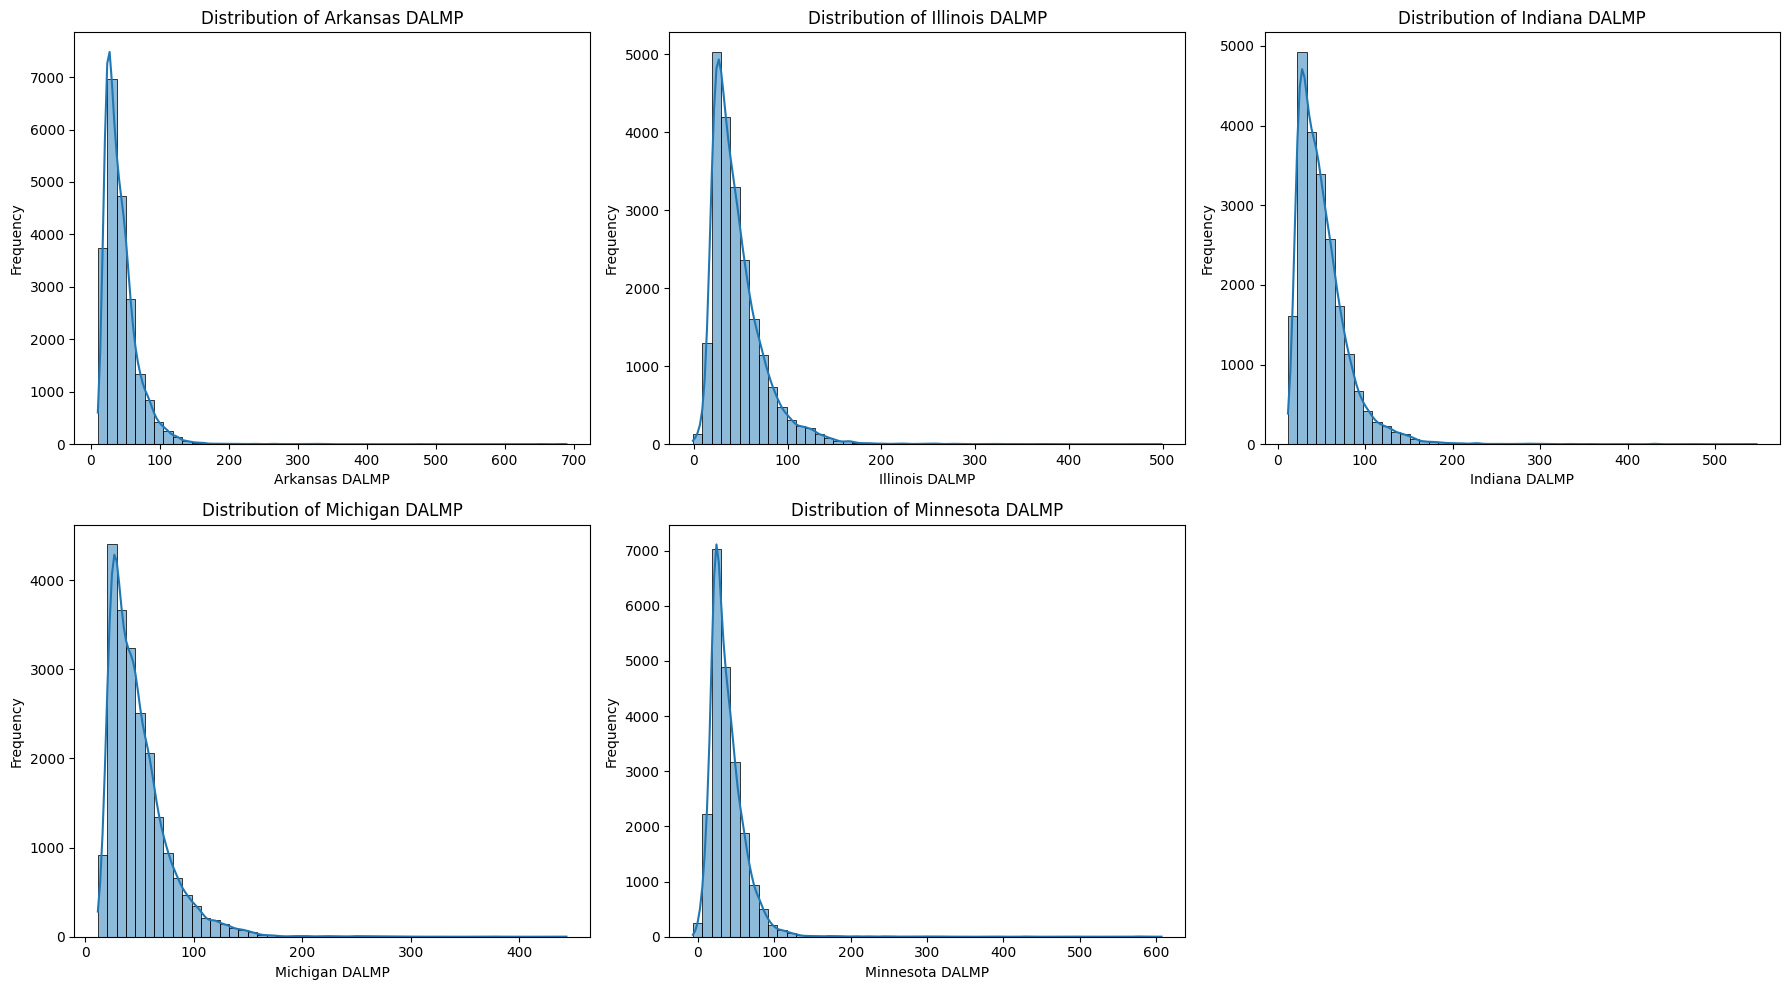

In [ ]:
plot_hist(df_combined, col_DA_LMP)

Histograms for RT Prices:

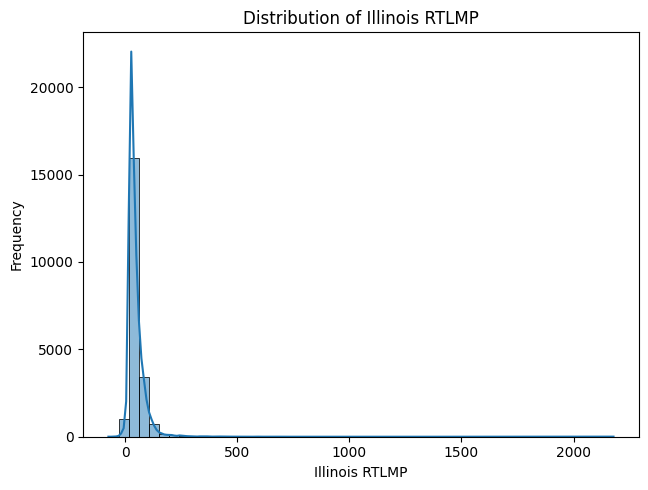

In [ ]:
plot_hist(df_combined, col_RT_LMP[1:2])

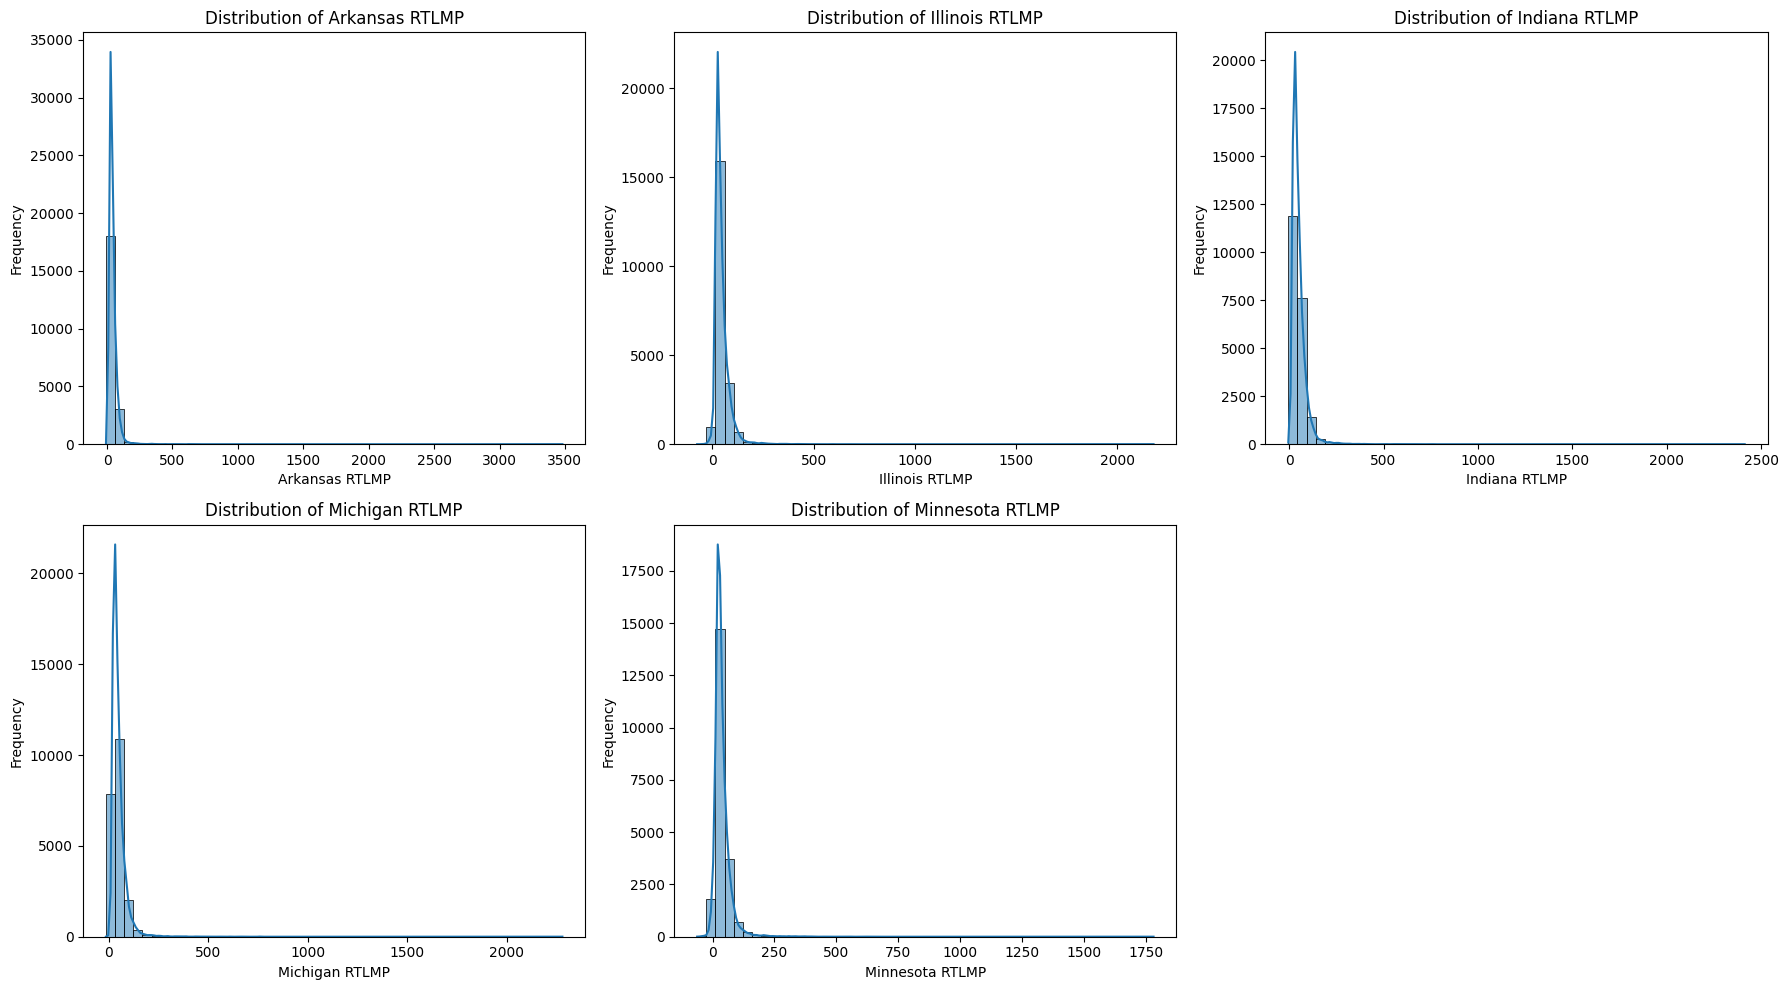

In [ ]:
plot_hist(df_combined, col_RT_LMP)

### Loads
**Summary:** The distribution is approximately Gaussian in its central mass but has an additional one-sided tail toward larger load values; the tail is present but less extreme than for prices.

**Interpretation:** This suggests a near-normal baseline demand pattern with some high-load episodes (positive skew). I think regular normalization with mean and standard deviation would suffice.

Histograms for the actual load:


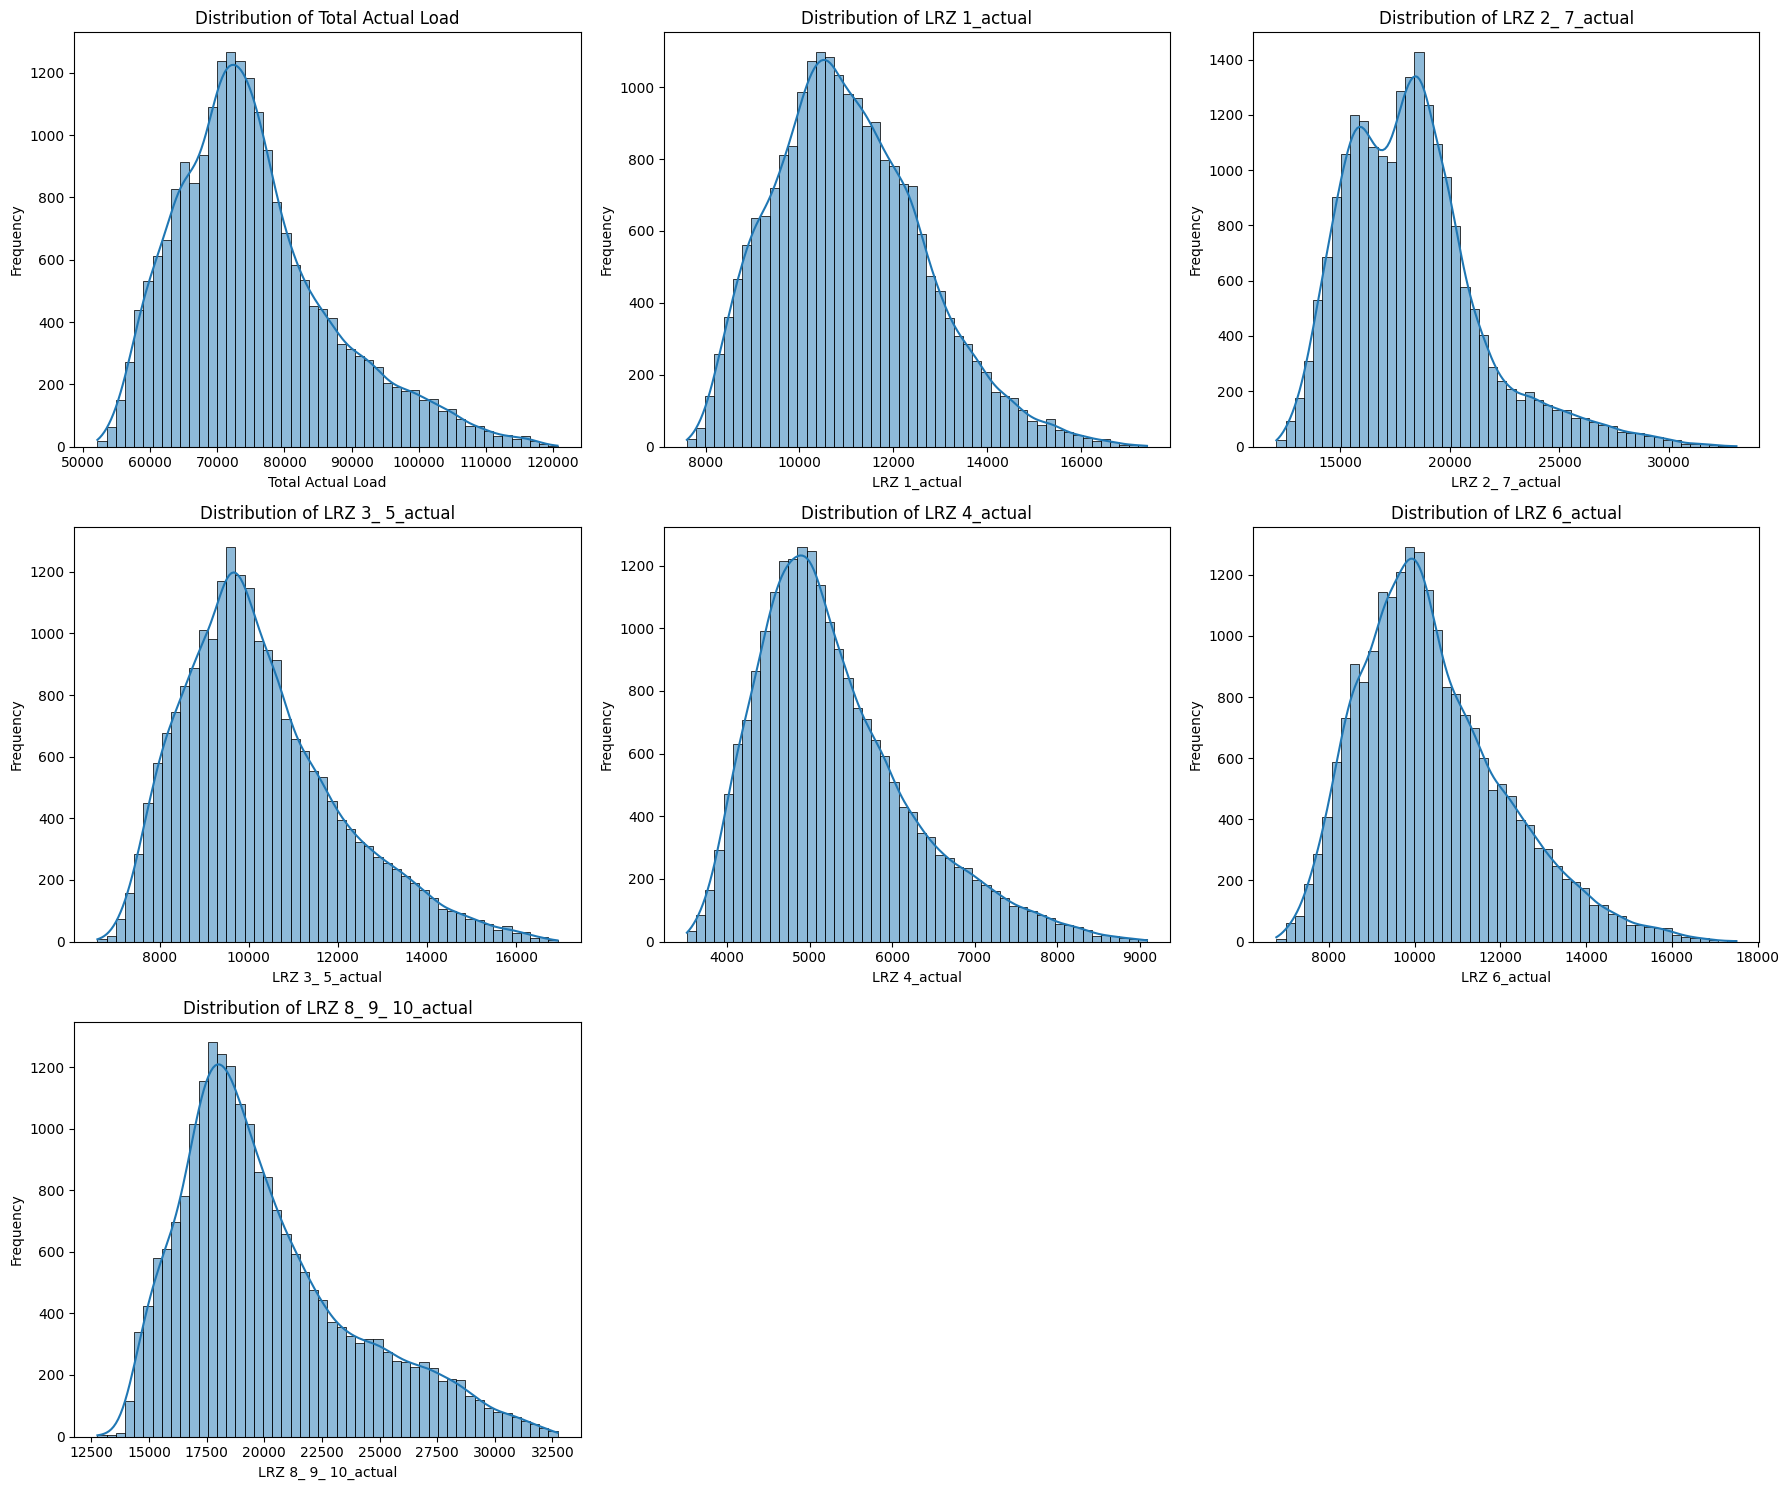

In [ ]:
plot_hist(df_combined, col_load_act)

Histograms for the forecasted loads:

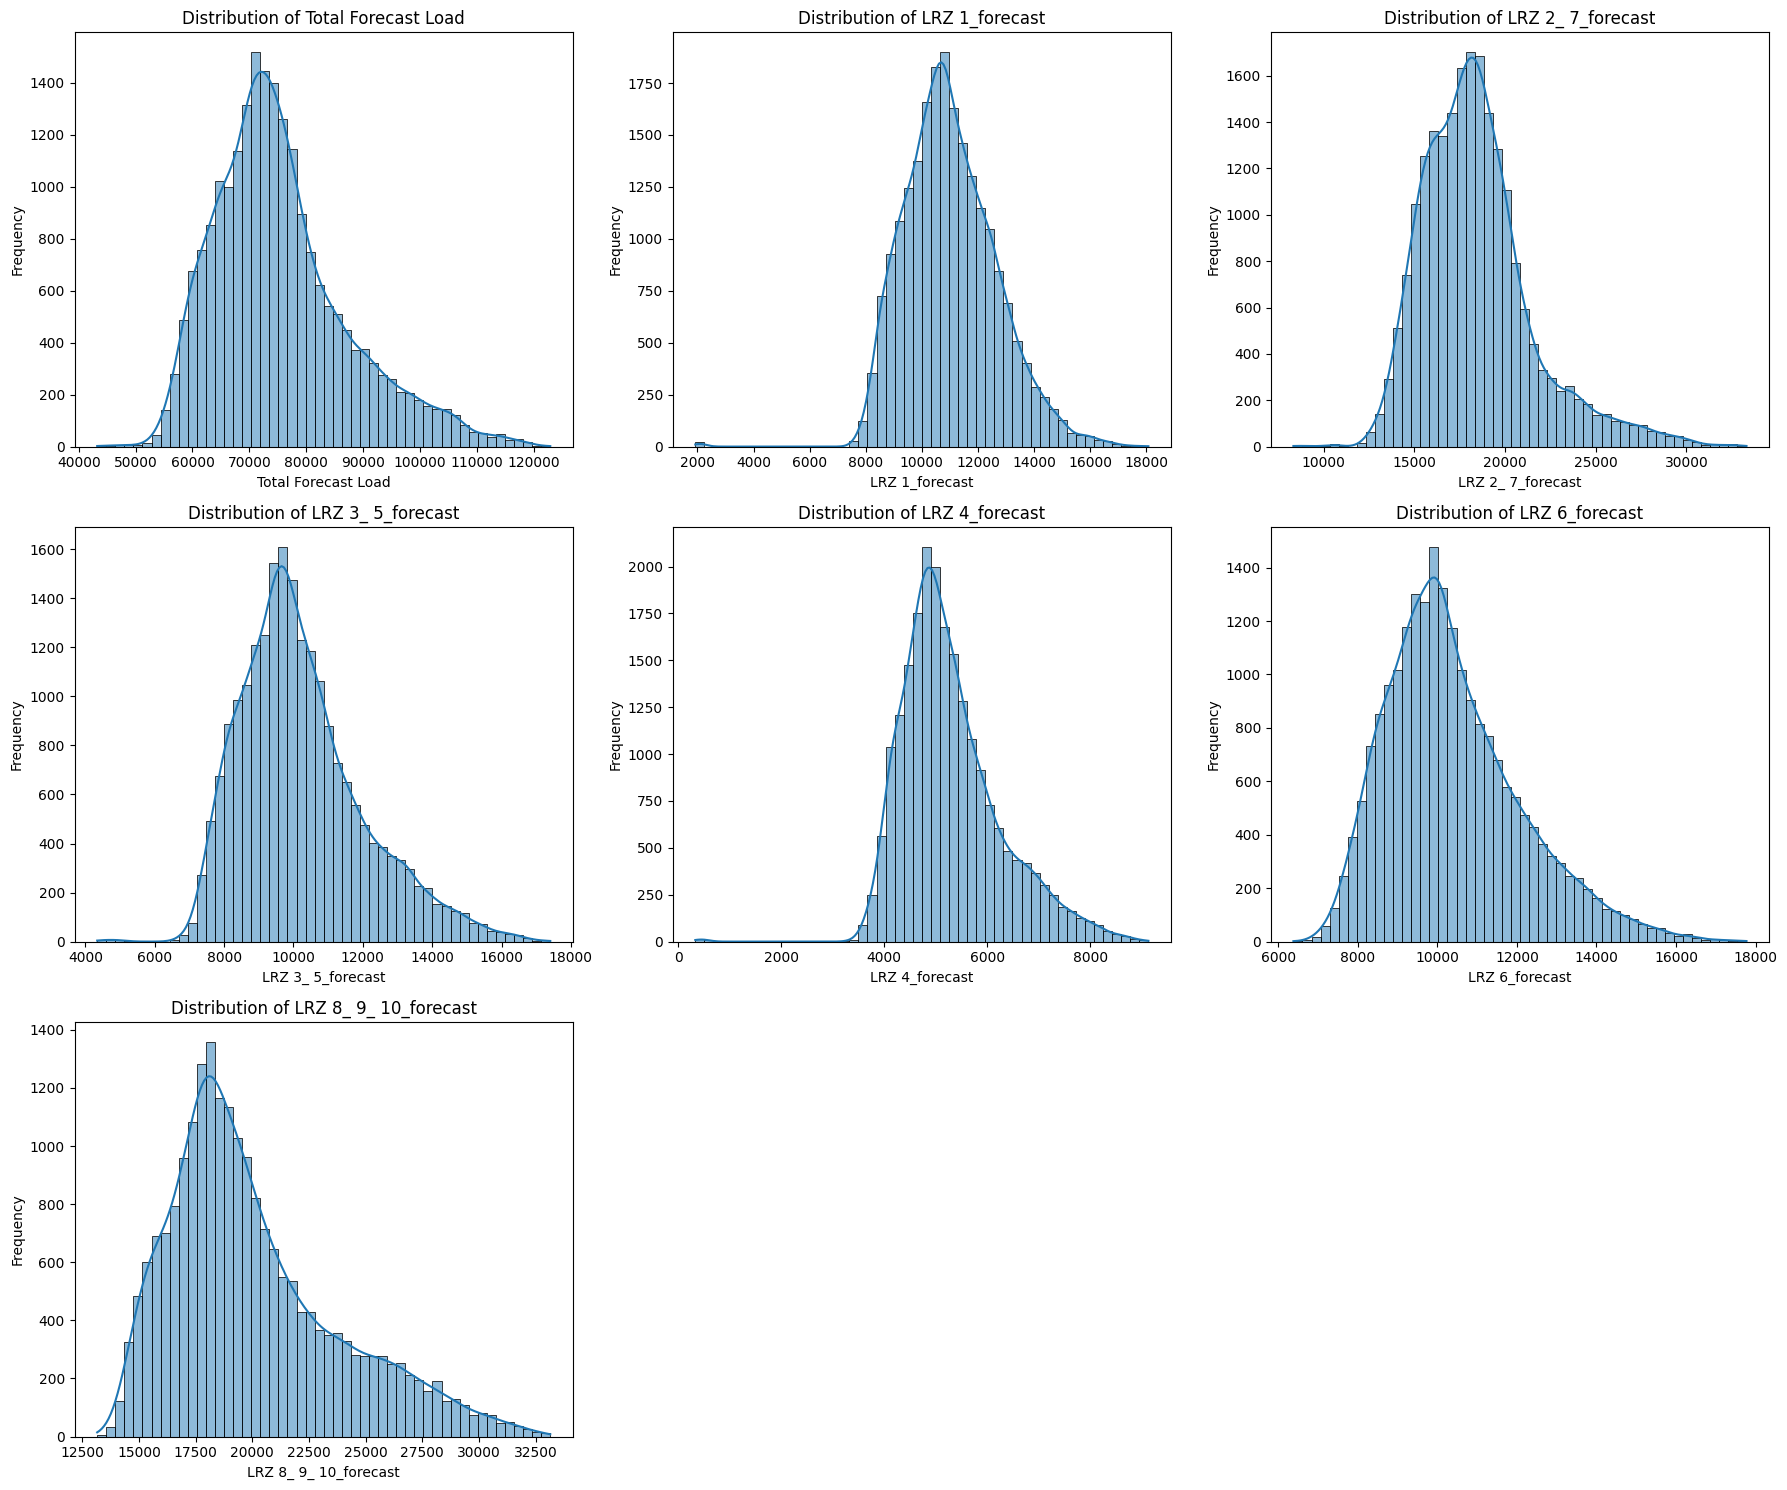

In [ ]:
plot_hist(df_combined, col_load_forecast)

Actual vs Forecasted Load

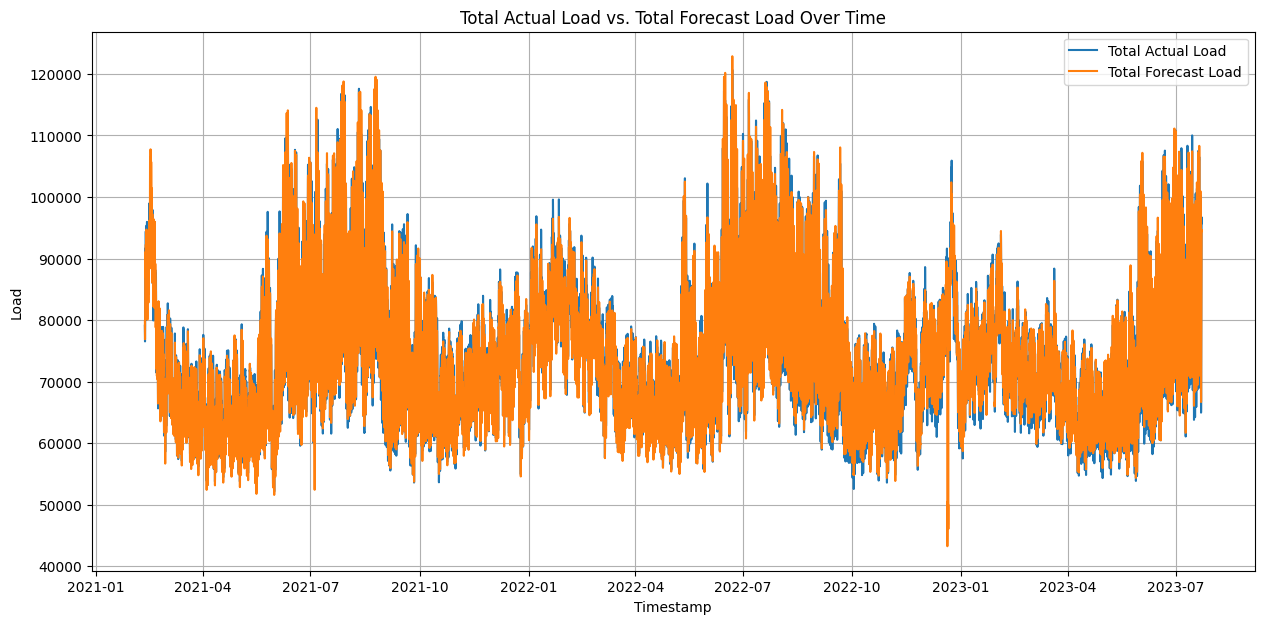

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='Timestamp', y='Total Actual Load', data=df_combined, label='Total Actual Load')
sns.lineplot(x='Timestamp', y='Total Forecast Load', data=df_combined, label='Total Forecast Load')
plt.title('Total Actual Load vs. Total Forecast Load Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.show()

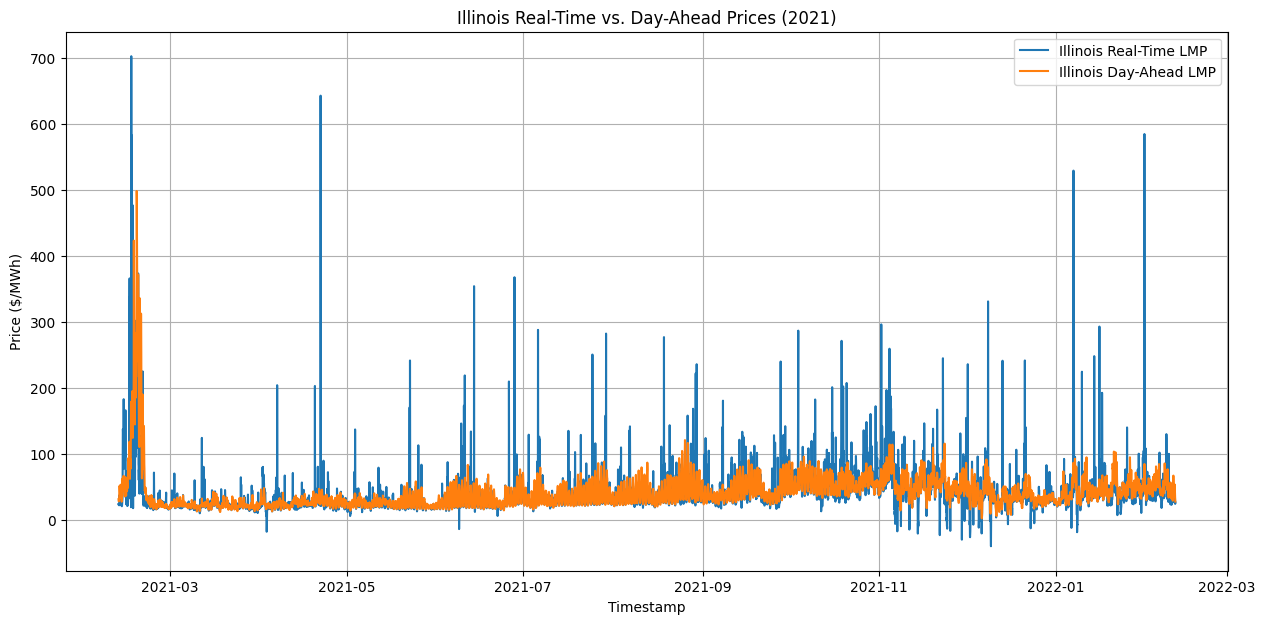

In [ ]:
start_date = df_combined['Timestamp'].min()
end_date = start_date + pd.DateOffset(years=1)
df_one_year = df_combined[(df_combined['Timestamp'] >= start_date) & (df_combined['Timestamp'] < end_date)]

plt.figure(figsize=(15, 7))
sns.lineplot(x='Timestamp', y='Illinois RTLMP', data=df_one_year, label='Illinois Real-Time LMP')
sns.lineplot(x='Timestamp', y='Illinois DALMP', data=df_one_year, label='Illinois Day-Ahead LMP')
plt.title(f'Illinois Real-Time vs. Day-Ahead Prices ({start_date.year})')
plt.xlabel('Timestamp')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.grid(True)
plt.show()

### Temperature
**Summary:** The distribution resembles a Gaussian mixture with two modes, consistent with two underlying regimes (cold-weather and hot-weather conditions).

**Interpretation:** This implies the data are generated by at least two distinct temperature regimes rather than a single unimodal process. However, I will use a naive normalization for these data.

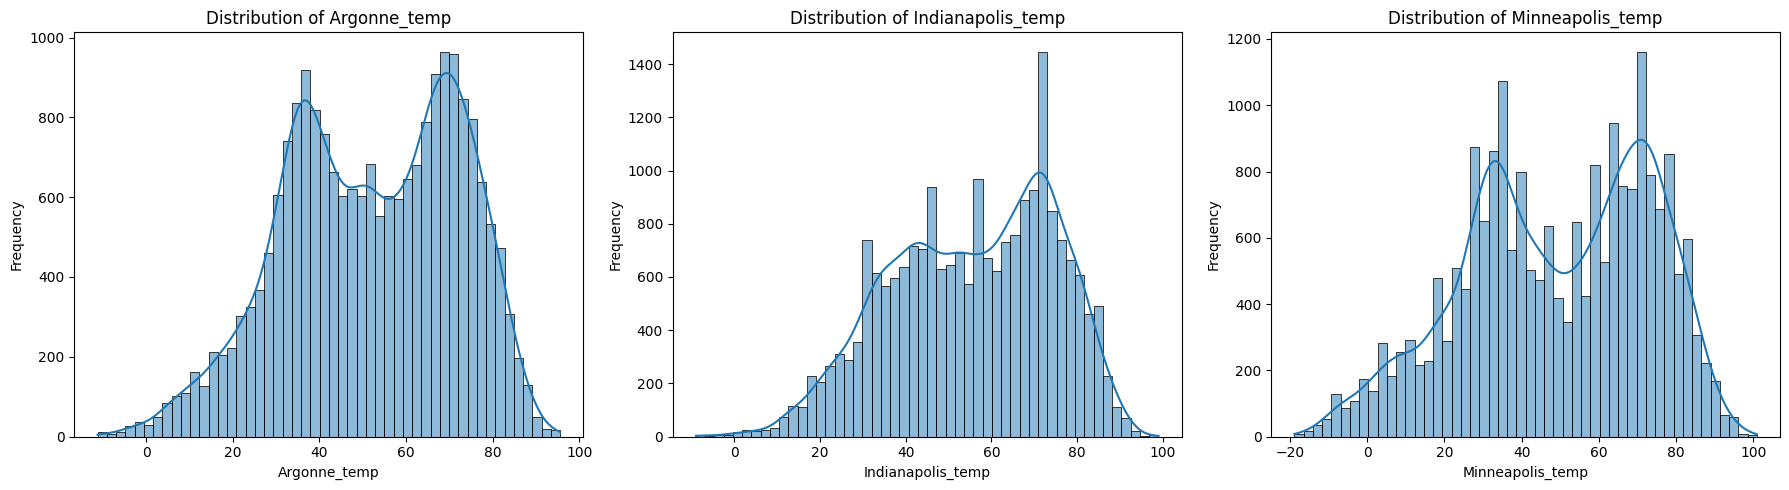

In [ ]:
plot_hist(df_combined, col_temp)

# Feature Engineering

## Seasonality
Energy prices have strong seasonality (hour-of-day, day-of-week, month/season). Giving the model time context usually helps, especially for next-hour forecasting. Our feature set includes cyclical data using sine and cosine transformations for hour, week, and month. Since we are using neural networks, including these data will help with seasonality.

## Discussion of the next steps
We have 34 initial features including the cyclical features now.

We want to
- Observe the correlation in the data and do some initial elimination of features.
- We want to add some lagged fetures.
- We want to do all these while avoiding leakage.

Let's think about these questions:
1.  Should we split the dataset into training/validation/testing before we do the correlation test?
2. Should we select the lagged features before the correlation test? Should we do it before splitting?
3. How should we do the correlation analysis? How should we decide which lagged features to add? How should we split the data cosidering this is a time series problem?  

My reasoning for the **first question** is that we should do feature selection/elimination (dropping predictors, deciding which lags to include, etc.) using training set only because:
- The test period may have different price regimes (volatility spikes, seasonality changes).
- Correlation estimates from the future can bias our design choices.

I think a good compromise is
- Make the split.
- Do correlations on train to make decisions.
- Verify our choices are not bad by checking if relationships are broadly similar on the validation set.


For validation and testing sets, when predicting times in these periods, we  have access to historical values from before the split (for example yesterday's price). My answer for the **second question** is choosing what's practical:

- Do a chronological split.
- Choose features (including the lagged ones).
- When we later scale/normalize, we fit scalers on the training set  only, then apply it to the validation and the testing sets.

This process avoids leakage because the lags only use past information. Now, let's answer:


**How should we split the data?**

Obviously, we should shuffle because this is a time series problem.
A lot of sources recommend using rolling window for training and validation. But, I am not sure how to  approach the goals I listed above without leakage  with a rolling training/validation set. _This is left as future work_.
I will split the data chronologically:
- Train: earliest 70%
- Validation: next 15%
- Test: last 15%

**How should we decide which lagged features to add?**  
**How should we do the correlation analysis?**
1. We will start with the most predictive lag family: target autocorrelation. Because I expect LMPs to be  strongly autoregressive.
2. Check cross-correlation with other features and `Illinois RTLMP[t+1]`.

Recall our histogram plots. We will use Spearman for correlation analysis because it's more robust to spikes and outliers and doesn't assume linearity.


## Split Data
I will split the data chronologically:
- Train: earliest 70%
- Validation: next 15%
- Test: last 15%

We will choose features based on the training data.

In [ ]:
n = len(df_combined)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)   # 70% + 15%

train_df = df_combined.iloc[:train_end].copy()
val_df   = df_combined.iloc[train_end:val_end].copy()
test_df  = df_combined.iloc[val_end:].copy()

## Lagged Features
A reasonable set of lags would be
- Illinois RTLMP/DALMP: `k = 1,2,...,24,168`
- Other nodes RTLMP/DALMP:`k = 1,24,168`
- Load actual/forecast: `k = 1,2,24,168`

This lag set balances short-term dynamics while keeping the feature space manageable. For Illinois RTLMP/DALMP, scanning up to 24 plus 168 captures strong autoregressive behavior and daily/weekly cycles. For other hub's prices, a smaller set  captures immediate and shared daily/weekly structure. For load, k = 0, 1, 3 targets near-term ramp effects and 24/168 captures recurring demand patterns.

## Autoregressive correlation
See the Spearman correlation between `Illinois RTLMP[t]` and lagged `Illinois RTLMP` and `Illinois DALMP`. This methid is able to detect nonlinear-but-monotone relationships and it is less sensitive to scale change. As we can see, all correlation is above 0.5. But, I think this is due to seasonality.

I will choose:
- `Illinois RTLMP` with `k = 0,1,2,3,23`
- `Illinois DALMP` with `k = -1`. Although $\rho$ values of the lagged features are high, we already have the real time prices for these samples.

**Remark:** Target is t+1, thus k is how much we shift t.

In [ ]:
RTL_COL = "Illinois RTLMP"
DAL_COL = "Illinois DALMP"
LAGS = list(range(1, 25)) + [168]   # 1..24 and 168

def spearman_corr(base: pd.Series, other: pd.Series):
    valid = pd.concat([base, other], axis=1).dropna()
    n = len(valid)
    if n < 3:
        # spearmanr can behave oddly with tiny n; p-value not meaningful
        return np.nan, np.nan, n

    rho, p = spearmanr(valid.iloc[:, 0].values, valid.iloc[:, 1].values)
    return rho, p, n

def corr_table(df: pd.DataFrame, base_col: str, target_col: str, lags, include_current=False):
    base = df[base_col]
    rows = []

    if include_current:
        rho, p, n = spearman_corr(base, df[target_col])
        rows.append({"shift_k": 0, "spearman_rho": rho, "p_value": p, "n_obs": n})

    for k in lags:
        rho, p, n = spearman_corr(base, df[target_col].shift(k))
        rows.append({"shift_k": k, "spearman_rho": rho, "p_value": p, "n_obs": n})

    out = (
        pd.DataFrame(rows)
        .sort_values("spearman_rho", ascending=False, na_position="last")
        .reset_index(drop=True)
    )
    return out

# Table 1: RTLMP vs lagged RTLMP
tbl_rtlmp = corr_table(train_df, RTL_COL, RTL_COL, LAGS, include_current=False)

# Table 2: RTLMP vs current + lagged DALMP
tbl_dalmp = corr_table(train_df, RTL_COL, DAL_COL, LAGS, include_current=True)

print("\n=== Spearman: Illinois RTLMP vs Illinois RTLMP (lags 1..24, 168) ===")
print(tbl_rtlmp.to_string(index=False))

print("\n=== Spearman: Illinois RTLMP vs Illinois DALMP (current + lags 1..24, 168) ===")
print(tbl_dalmp.to_string(index=False))



=== Spearman: Illinois RTLMP vs Illinois RTLMP (lags 1..24, 168) ===
 shift_k  spearman_rho  p_value  n_obs
       1      0.907592      0.0  14980
       2      0.844719      0.0  14979
       3      0.793211      0.0  14978
       4      0.744108      0.0  14977
      24      0.719178      0.0  14957
      23      0.712758      0.0  14958
       5      0.697674      0.0  14976
      22      0.691177      0.0  14959
      21      0.666796      0.0  14960
       6      0.655928      0.0  14975
     168      0.639971      0.0  14813
      20      0.638834      0.0  14961
       7      0.620400      0.0  14974
      19      0.615690      0.0  14962
       8      0.593349      0.0  14973
      18      0.590068      0.0  14963
       9      0.574213      0.0  14972
      17      0.568438      0.0  14964
      10      0.560291      0.0  14971
      16      0.552193      0.0  14965
      11      0.551960      0.0  14970
      12      0.544995      0.0  14969
      15      0.541803      0.0  

## Correlation with other hub prices
See the Spearman correlation between `Illinois RTLMP` and lagged `RTLMP` and `DALMP` of other hubs.

- RTLMP of Michigan, Indiana, and Arkansas with `k=1,24` are very informative. We will pick these. Since we are predicting t+1, we will choose `k=0,23`.
- DALMP prices of these these states with `k=0,1,24` along with Minnesota DALMP with `k=0` are very informative. We will only pick DALMP with `k=0`. Again, although  𝜌  values of the lagged features are high, we already have the real time prices for these samples. So, we choose `k=-1`.

In [ ]:


BASE_COL = "Illinois RTLMP"
STATES = ["Arkansas", "Indiana", "Michigan", "Minnesota"]

RTL_LAGS = [1, 24, 168]
DAL_LAGS = [0, 1, 24, 168]

def spearman_with_p(base: pd.Series, other: pd.Series):
    valid = pd.concat([base, other], axis=1).dropna()
    n = len(valid)
    if n < 3:
        return np.nan, np.nan, n
    rho, p = spearmanr(valid.iloc[:, 0].values, valid.iloc[:, 1].values)
    return rho, p, n

def get_col(df: pd.DataFrame, state: str, kind: str):
    # expects columns like "Arkansas RTLMP", "Michigan DALMP", etc.
    name = f"{state} {kind}"
    if name in df.columns:
        return name
    # fallback: case-insensitive match
    target = name.lower()
    for c in df.columns:
        if str(c).lower() == target:
            return c
    raise KeyError(f"Column not found: '{name}'")

def corr_table_other_nodes(df: pd.DataFrame, base_col: str, states, kind: str, lags):
    base = df[base_col]
    rows = []

    for st in states:
        col = get_col(df, st, kind)

        for k in lags:
            series = df[col] if k == 0 else df[col].shift(k)
            rho, p, n = spearman_with_p(base, series)

            rows.append({
                "state": st,
                "column": col,
                "shift_k": k,
                "spearman_rho": rho,
                "p_value": p,
                "n_obs": n
            })

    out = (pd.DataFrame(rows)
           .sort_values("spearman_rho", ascending=False, na_position="last")
           .reset_index(drop=True))
    return out

# --- compute tables ---
tbl_rtlmp_other = corr_table_other_nodes(train_df, BASE_COL, STATES, "RTLMP", RTL_LAGS)
tbl_dalmp_other = corr_table_other_nodes(train_df, BASE_COL, STATES, "DALMP", DAL_LAGS)

print("\n=== Spearman: Illinois RTLMP vs Other RTLMP (k = 1,24,168) ===")
print(tbl_rtlmp_other.to_string(index=False))

print("\n=== Spearman: Illinois RTLMP vs Other DALMP (k = 0,1,24,168) ===")
print(tbl_dalmp_other.to_string(index=False))



=== Spearman: Illinois RTLMP vs Other RTLMP (k = 1,24,168) ===
    state          column  shift_k  spearman_rho  p_value  n_obs
 Michigan  Michigan RTLMP        1      0.841810      0.0  14980
  Indiana   Indiana RTLMP        1      0.813233      0.0  14980
 Arkansas  Arkansas RTLMP        1      0.797008      0.0  14980
 Michigan  Michigan RTLMP       24      0.739154      0.0  14957
 Arkansas  Arkansas RTLMP       24      0.738003      0.0  14957
  Indiana   Indiana RTLMP       24      0.726879      0.0  14957
 Arkansas  Arkansas RTLMP      168      0.682470      0.0  14813
 Michigan  Michigan RTLMP      168      0.677251      0.0  14813
  Indiana   Indiana RTLMP      168      0.662653      0.0  14813
Minnesota Minnesota RTLMP        1      0.587309      0.0  14980
Minnesota Minnesota RTLMP       24      0.541744      0.0  14957
Minnesota Minnesota RTLMP      168      0.442883      0.0  14813

=== Spearman: Illinois RTLMP vs Other DALMP (k = 0,1,24,168) ===
    state          column

## Correlation with load
Overall verdict: load is a solid, meaningful predictor of Illinois RTLMP, but it's not the dominant driver compared to price's own persistence/seasonality.
Also, load forecasts are used for deciding DALMP prices.

I will keep
- Total Forecast Load, LRZ 4_forecast, LRZ 8_ 9_ 10_forecast with k = -1
- Total Actual Load with k = 0.


In [ ]:
BASE_COL = "Illinois RTLMP"

FORECAST_LAGS = [0, 1, 2, 24, 168]
ACTUAL_LAGS   = [1, 2, 24, 168]

FORECAST_FEATURES = [
    "Total Forecast Load",
    "LRZ 1_forecast",
    "LRZ 2_ 7_forecast",
    "LRZ 3_ 5_forecast",
    "LRZ 4_forecast",
    "LRZ 6_forecast",
    "LRZ 8_ 9_ 10_forecast",
]

ACTUAL_FEATURES = [
    "Total Actual Load",
    "LRZ 1_actual",
    "LRZ 2_ 7_actual",
    "LRZ 3_ 5_actual",
    "LRZ 4_actual",
    "LRZ 6_actual",
    "LRZ 8_ 9_ 10_actual",
]

def spearman_with_p(base: pd.Series, other: pd.Series):
    valid = pd.concat([base, other], axis=1).dropna()
    n = len(valid)
    if n < 3:
        return np.nan, np.nan, n
    rho, p = spearmanr(valid.iloc[:, 0].values, valid.iloc[:, 1].values)
    return rho, p, n

def get_col_case_insensitive(df: pd.DataFrame, name: str):
    if name in df.columns:
        return name
    target = name.lower()
    for c in df.columns:
        if str(c).lower() == target:
            return c
    raise KeyError(f"Column not found: '{name}'")

def corr_table_features(df: pd.DataFrame, base_col: str, features, lags):
    base = df[base_col]
    rows = []

    for feat in features:
        col = get_col_case_insensitive(df, feat)

        for k in lags:
            s = df[col] if k == 0 else df[col].shift(k)  # k hours in the past
            rho, p, n = spearman_with_p(base, s)

            rows.append({
                "feature": feat,
                "shift_k": k,
                "spearman_rho": rho,
                "p_value": p,
                "n_obs": n
            })

    out = (pd.DataFrame(rows)
           .sort_values("spearman_rho", ascending=False, na_position="last")
           .reset_index(drop=True))
    return out

# --- compute ---
tbl_forecast_load = corr_table_features(train_df, BASE_COL, FORECAST_FEATURES, FORECAST_LAGS)
tbl_actual_load   = corr_table_features(train_df, BASE_COL, ACTUAL_FEATURES, ACTUAL_LAGS)

print("\n=== Spearman: Illinois RTLMP vs Forecast Load Features (k = 0,1,2,24,168) ===")
print(tbl_forecast_load.to_string(index=False))

print("\n=== Spearman: Illinois RTLMP vs Actual Load Features (k = 1,2,24,168) ===")
print(tbl_actual_load.to_string(index=False))



=== Spearman: Illinois RTLMP vs Forecast Load Features (k = 0,1,2,24,168) ===
              feature  shift_k  spearman_rho       p_value  n_obs
LRZ 8_ 9_ 10_forecast        0      0.466990  0.000000e+00  14981
  Total Forecast Load        0      0.463952  0.000000e+00  14981
    LRZ 2_ 7_forecast        0      0.454855  0.000000e+00  14981
       LRZ 4_forecast        0      0.441315  0.000000e+00  14981
    LRZ 2_ 7_forecast        1      0.441178  0.000000e+00  14980
  Total Forecast Load        1      0.440841  0.000000e+00  14980
LRZ 8_ 9_ 10_forecast       24      0.440415  0.000000e+00  14957
LRZ 8_ 9_ 10_forecast        1      0.439422  0.000000e+00  14980
    LRZ 3_ 5_forecast        0      0.432138  0.000000e+00  14981
  Total Forecast Load       24      0.428969  0.000000e+00  14957
       LRZ 4_forecast        1      0.415538  0.000000e+00  14980
LRZ 8_ 9_ 10_forecast      168      0.412977  0.000000e+00  14813
    LRZ 2_ 7_forecast        2      0.411166  0.000000e+00  149

## Correlation with Temperature
Spearman isn't a great measure for temperature vs price because it only detects monotonic relationships (price consistently rising or falling as temperature rises), while electricity prices typically respond to temperature in a U-shaped way: prices rise when it's too hot (A/C load) and when it's too cold (heating load).

We will keep Indianapolis and Argonne temperature forecasts.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

PRICE_COL = "Illinois RTLMP"
TEMP_COLS = ["Argonne_temp", "Indianapolis_temp", "Minneapolis_temp"]

BASE_TEMP = 50

def spearman_with_p(x: pd.Series, y: pd.Series):
    valid = pd.concat([x, y], axis=1).dropna()
    n = len(valid)
    if n < 3:
        return np.nan, np.nan, n
    rho, p = spearmanr(valid.iloc[:, 0].values, valid.iloc[:, 1].values)
    return rho, p, n

rows = []
price = df_combined[PRICE_COL]

for col in TEMP_COLS:
    T = df_combined[col]

    # Keep only "active" regimes (otherwise NaN)
    CDD = (T - BASE_TEMP).where(T > BASE_TEMP)      # NaN if T <= BASE
    HDD = (BASE_TEMP - T).where(T < BASE_TEMP)      # NaN if T >= BASE

    for feature_name, series in [
        (f"{col}", T),  # raw temp (full sample)
        (f"{col}_CDD_active_base{BASE_TEMP}", CDD),  # only hot hours
        (f"{col}_HDD_active_base{BASE_TEMP}", HDD),  # only cold hours
    ]:
        rho, p, n = spearman_with_p(price, series)
        rows.append({
            "feature": feature_name,
            "spearman_rho": rho,
            "p_value": p,
            "n_obs": n
        })

tbl_temp = (
    pd.DataFrame(rows)
    .sort_values(["feature"], ascending=True)
    .reset_index(drop=True)
)

print("\n=== Spearman: Illinois RTLMP vs Temperature Forecast Features (k=0 only) ===")
print(tbl_temp.to_string(index=False))



=== Spearman: Illinois RTLMP vs Temperature Forecast Features (k=0 only) ===
                            feature  spearman_rho       p_value  n_obs
                       Argonne_temp      0.184408 4.950766e-163  21402
     Argonne_temp_CDD_active_base50      0.350298  0.000000e+00  11562
     Argonne_temp_HDD_active_base50      0.197131  2.472305e-86   9787
                  Indianapolis_temp      0.189495 3.347731e-172  21402
Indianapolis_temp_CDD_active_base50      0.374891  0.000000e+00  12831
Indianapolis_temp_HDD_active_base50      0.259969 2.675196e-127   8235
                   Minneapolis_temp      0.172056 7.218859e-142  21402
 Minneapolis_temp_CDD_active_base50      0.238868 9.696902e-138  10625
 Minneapolis_temp_HDD_active_base50      0.112899  2.586124e-31  10564


# Preparing Dataset with Selected Features
- Timestamp
- Illinois RTLMP Target: Illinois RTLMP, k=-1
- Arkansas RTLMP, k = 0,23
- Illinois RTLMP, k = 0,1,2,3,23
- Indiana RTLMP,	k = 0,23
- Michigan RTLMP,	k = 0,23
- Arkansas DALMP,	k=-1
- Illinois DALMP,	k=-1
- Indiana DALMP,	k=-1
- Michigan DALMP,	k=-1
- Total Actual Load,	k=0
- Total Forecast Load, k = -1
- LRZ 4_forecast,	k=-1
- LRZ 8_ 9_ 10_forecast, k=-1
- Argonne_temp,  k=-1
- Indianapolis_temp	k=-1
- week_sin, k = -1
- week_cos, k=-1
- hour_sin, k=-1
- hour_cos, k=-1
- month_sin,k=-1
- month_cos,k=-1

In [ ]:
out = pd.DataFrame({"Timestamp": df_combined["Timestamp"]})

def add_shift(src_col: str, k: int, new_name: str | None = None):
    if new_name is None:
        new_name = src_col if k == 0 else f"{src_col}_k{k}"
    out[new_name] = df_combined[src_col].shift(k)

# --- Target ---
add_shift("Illinois RTLMP", -1, "Illinois RTLMP Target")  # Illinois RTLMP Target: Illinois RTLMP, k=-1

# --- RTLMP features ---
add_shift("Arkansas RTLMP", 0)
add_shift("Arkansas RTLMP", 23, "Arkansas RTLMP_k23")

add_shift("Illinois RTLMP", 0)
add_shift("Illinois RTLMP", 1,  "Illinois RTLMP_k1")
add_shift("Illinois RTLMP", 2,  "Illinois RTLMP_k2")
add_shift("Illinois RTLMP", 3,  "Illinois RTLMP_k3")
add_shift("Illinois RTLMP", 23, "Illinois RTLMP_k23")

add_shift("Indiana RTLMP", 0)
add_shift("Indiana RTLMP", 23, "Indiana RTLMP_k23")

add_shift("Michigan RTLMP", 0)
add_shift("Michigan RTLMP", 23, "Michigan RTLMP_k23")

# --- DALMP features (k=-1) ---
add_shift("Arkansas DALMP", -1, "Arkansas DALMP_k-1")
add_shift("Illinois DALMP", -1, "Illinois DALMP_k-1")
add_shift("Indiana DALMP",  -1, "Indiana DALMP_k-1")
add_shift("Michigan DALMP", -1, "Michigan DALMP_k-1")

# --- Load / forecast features ---
add_shift("Total Actual Load", 0)
add_shift("Total Forecast Load", -1, "Total Forecast Load_k-1")
add_shift("LRZ 4_forecast", -1, "LRZ 4_forecast_k-1")
add_shift("LRZ 8_ 9_ 10_forecast", -1, "LRZ 8_ 9_ 10_forecast_k-1")

# --- Weather + cyclical features (k=-1) ---
add_shift("Argonne_temp", -1, "Argonne_temp_k-1")
add_shift("Indianapolis_temp", -1, "Indianapolis_temp_k-1")

add_shift("week_sin",  -1, "week_sin_k-1")
add_shift("week_cos",  -1, "week_cos_k-1")
add_shift("hour_sin",  -1, "hour_sin_k-1")
add_shift("hour_cos",  -1, "hour_cos_k-1")
add_shift("month_sin", -1, "month_sin_k-1")
add_shift("month_cos", -1, "month_cos_k-1")

# 3) Drop rows made invalid by shifting (edges) and finish
df_final = out.dropna().reset_index(drop=True)


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21378 entries, 0 to 21377
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Timestamp                  21378 non-null  datetime64[ns]
 1   Illinois RTLMP Target      21378 non-null  float64       
 2   Arkansas RTLMP             21378 non-null  float64       
 3   Arkansas RTLMP_k23         21378 non-null  float64       
 4   Illinois RTLMP             21378 non-null  float64       
 5   Illinois RTLMP_k1          21378 non-null  float64       
 6   Illinois RTLMP_k2          21378 non-null  float64       
 7   Illinois RTLMP_k3          21378 non-null  float64       
 8   Illinois RTLMP_k23         21378 non-null  float64       
 9   Indiana RTLMP              21378 non-null  float64       
 10  Indiana RTLMP_k23          21378 non-null  float64       
 11  Michigan RTLMP             21378 non-null  float64       
 12  Mich

# Pickle the Final Dataset

In [ ]:
datadir = '/content/drive/MyDrive/miso_project'
data_pickled_dir = os.path.join(datadir, 'data_pickled')
os.makedirs(data_pickled_dir, exist_ok=True)

#  Prepare 2 months worth of data for debugging
start_date = df_final['Timestamp'].min()
end_date_debug = start_date + timedelta(days=60) # Approximately 2 months
df_debug = df_final[df_final['Timestamp'] <= end_date_debug].copy()

# Save debugging data
debug_file_path = os.path.join(data_pickled_dir, 'df_final_debug.pkl')
with open(debug_file_path, 'wb') as f:
    pickle.dump(df_debug, f)
print(f"Debugging data (2 months) saved to: {debug_file_path}")

Debugging data (2 months) saved to: /content/drive/MyDrive/miso_project/data_pickled/df_final_debug.pkl


In [ ]:
# Pickle working data (all)
working_file_path = os.path.join(data_pickled_dir , 'df_final_working.pkl')
with open(working_file_path, 'wb') as f:
    pickle.dump(df_final, f)
print(f"Working data (all data) saved to: {working_file_path}")

Working data (all data) saved to: /content/drive/MyDrive/miso_project/data_pickled/df_final_working.pkl


In [ ]:
# Display basic info for confirmation
print(f"\nShape of debugging DataFrame: {df_debug.shape}")
print(f"Shape of working DataFrame: {df_final.shape}")


Shape of debugging DataFrame: (1441, 29)
Shape of working DataFrame: (21378, 29)
